## Heart Attack Prediction Model 
## Final Model Interpretation
## Business Solutions

---


## Author: Will Wu

## Date: 2025-04-02
---

## Introduction
This notebook is composed of three sections:
1. Interpreting the final model: **to be filled**
2. Analysis of false negatives and false positives: **to be filled**
3. Project Summary and Insights: **to be filled**

---

## **Table of Contents** ##
1. [Setup and Load Data](#1)
2. [Reproduct the Predictions](#2)
3. [Interpreting the Models](#2)


---

## 1. Setup and Loading<a class="anchor" id="1"></a>

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  roc_auc_score, roc_curve
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import joblib
from model_evaluator import ModelEvaluator


In [2]:
# Configure Seaborn to use 'darkgrid' as the default background style
sns.set_style('darkgrid')

# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Filter warnings 
from warnings import filterwarnings
filterwarnings(action='ignore')

In [3]:
# Load the data with feature selection
df = pd.read_csv('../data/processed/df_feature_selected.csv')

In [4]:
# Check the top five rows
df.head(5)

,is_female,race_ethnicity_category,age_category,bmi_category,alcohol_drinkers,general_health,smoker_status,physical_activities,had_angina,had_stroke,had_copd,had_diabetes,had_kidney_disease,had_depressive_disorder,had_arthritis,deaf_or_hard_of_hearing,blind_or_vision_difficulty,difficulty_walking,difficulty_dressing_bathing,had_heart_attack
0,1,White,80+,obese,No,Very good,Never,0,0,0,No,Yes,No,No,No,No,No,Yes,No,0
1,1,White,80+,overweight,No,Very good,Never,1,0,0,No,No,No,Yes,Yes,Yes,No,No,No,0
2,1,Black,80+,healthy,No,Fair,Former,1,0,0,No,No,No,No,Yes,Unknown,Yes,Yes,No,0
3,1,White,75-79,overweight,No,Very good,Never,1,0,0,No,No,No,Yes,Yes,No,No,Yes,No,0
4,1,White,75-79,overweight,Yes,Fair,Never,1,0,0,No,Yes,No,Yes,Yes,No,No,Yes,No,0


In [5]:
# Load the final model: logistic regression
final_model = joblib.load("../models/final_model/pipeline_logreg_final.joblib")

# Load the threshold of the model
threshold_df = pd.read_csv("../models/final_model/logreg_threshold.csv")

In [6]:
# Check the threshold_df
threshold_df

,model,thresholds
0,logistic_regression,0.448738


In [7]:
# Store the threshold in as a variable
model_threshold = threshold_df.iloc[0, 1]

---

## 2. Reproduce the Predictions <a class="anchor" id="2"></a>

In this section, I will reproduce the predictions of the final model and re-evaluate its performance. The objectives are as follows:
1. Verify that the evaluation metrics align with those obtained during advanced modeling, ensuring that the predictions have been successfully reproduced.
2. Recap and analyze the confusion matrix, recall, and false positive rate of the model to assess its performance.

---

Create X and y

In [8]:
# Get X and y
X = df[[col for col in df.columns if col != 'had_heart_attack']]
y = df['had_heart_attack']

Train Test Split - Using the same random_state=42

In [9]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

Reproduce the predictions to verify if the evaluation metrics align with those obtained previously in the advanced modeling process.

In [29]:
# Use the self-built function to make predictions with specified model threshold
evaluator = ModelEvaluator(final_model)
y_pred_train, y_pred_test = evaluator.make_predictions(X_train, X_test, thresholds=model_threshold)

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

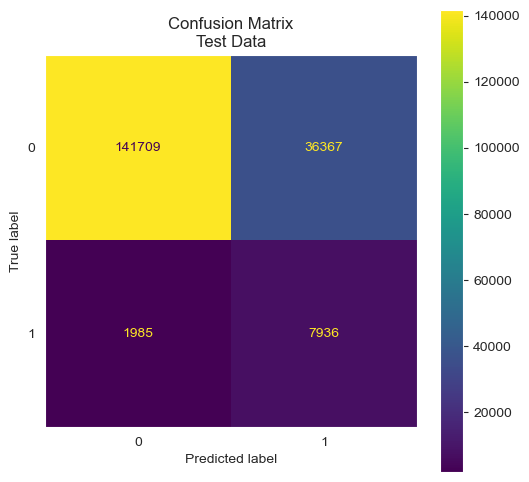

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.801
Test: 0.800 
False Positive Rate:
Train: 0.204
Test: 0.204 
AUC Score:
Train: 0.884
Test: 0.881 
Accuracy Score:
Train: 0.796
Test: 0.796 
Precision Score:
Train: 0.180
Test: 0.179 
F1 Score:
Train: 0.293
Test: 0.293 


In [30]:
# Reproduce model evaluation
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

ROC Curve: Logistic Regression Final Model


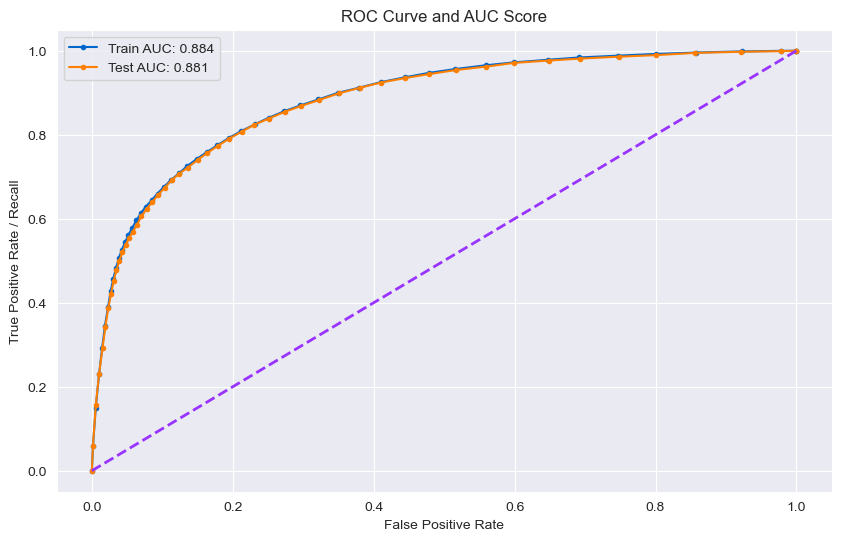

In [11]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Logistic Regression Final Model')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

All metrics match those from the advanced modeling, confirming that predictions on the training and test data have been successfully reproduced. I will now proceed to interpret the model.

---

## 3. Interpreting the Model/Coefficients <a class="anchor" id="3"></a>

- In this section, I will retrieve the coefficients from the logistic regression model, rank and plot the most impactful features, interpret their significance, and derive insights into the primary factors contributing to the risk of having a heart attack. Additionally, I will discuss potential preventive actions that can be taken to mitigate this risk.
- The logistic regression model is trained on scaled features, meaning that the coefficients correspond to the scaled feature space rather than the original feature space.
- To facilitate interpretation, I will convert the coefficients back to the original feature space, allowing them to be understood in terms of the odds of experiencing a heart attack.

---

### 3.1 Retrieve and Transform Coefficients <a class="anchor" id="3a"></a>

Retrieve the preprocessor (one-hot-encoder), scaler (standard scaler), and the logistic regresson model from the final_model pipeline

In [ ]:
# Get the one-hot-encoder from the final_model pipeline
preprocessor = final_model.named_steps['encoding'] 

# Get the standard scaler from the final_model pipeline
scaler = final_model.named_steps['scaler']

# Get the logistic regression model from the final_model pipeline
logreg = final_model.named_steps['logreg']

Retrieve the feature names after one hot encoding

In [80]:
# Get the feature names of the logistic regression
feature_names = preprocessor.get_feature_names_out()
feature_names[[0, 1, 2, -3, -2, -1]]

array(['cat_cols__race_ethnicity_category_Asian',
       'cat_cols__race_ethnicity_category_Black',
       'cat_cols__race_ethnicity_category_Hispanic',
       'num_cols__physical_activities', 'num_cols__had_angina',
       'num_cols__had_stroke'], dtype=object)

Due to one hot encoding, the feature names are not correctly displayed, I need to remove the 'cal_cols__' and 'num_cols__' in the beginning.

In [85]:
# Rename the features to remove starting pattern of cat_cols__ or num_cols__
feature_names = np.array([re.sub(r'(cat_cols__)|(num_cols__)', '', name) 
                          for name in feature_names])
feature_names[[0, 1, 2, -3, -2, -1]]

array(['race_ethnicity_category_Asian', 'race_ethnicity_category_Black',
       'race_ethnicity_category_Hispanic', 'physical_activities',
       'had_angina', 'had_stroke'], dtype='<U35')

To interpret the coefficients in the original feature space, we need to transform them back from their scaled version. The transformation can be done using the formula:

$$\text{unscaled\_coefficients} = \frac{\text{scaled\_coefficients}}{\text{standard deviation of the feature}}$$

In [86]:
# Retrieve and transform it in to unscaled coefficients
unscaled_coefficients = logreg.coef_[0] / scaler.scale_


In [87]:
# Create a DataFrame to store the feature names and coefficients
features = pd.DataFrame(
    data=unscaled_coefficients, 
    index=feature_names, 
    columns=['coefficients']
    ).sort_values(by='coefficients', ascending=False)

# Create a column to turn coefficients into change of odds of having a heart attack
features['odds'] = np.exp(features['coefficients'])

In [97]:
# Check the top 8 features
top_8_features = features.head(8)
top_8_features

,coefficients,odds
had_angina,2.190416,8.938930
had_stroke,1.077941,2.938622
age_category_80+,0.766557,2.152343
age_category_75-79,0.548910,1.731364
general_health_Poor,0.484267,1.622986
age_category_70-74,0.418379,1.519497
smoker_status_Every day smoker,0.361449,1.435408
general_health_Fair,0.350331,1.419537


In [99]:
# Check the bottom 8 features
bottom_8_features = features.tail(8)
bottom_8_features 

,coefficients,odds
age_category_45-49,-0.510853,0.599983
general_health_Excellent,-0.572801,0.563944
is_female,-0.592808,0.552773
age_category_40-44,-0.683696,0.504748
age_category_35-39,-0.910613,0.402278
age_category_30-34,-1.117730,0.327021
age_category_25-29,-1.304784,0.271231
age_category_18-24,-1.451391,0.234244


Plot the features

Text(0.5, 1.0, 'Top and Bottom 8 Features')

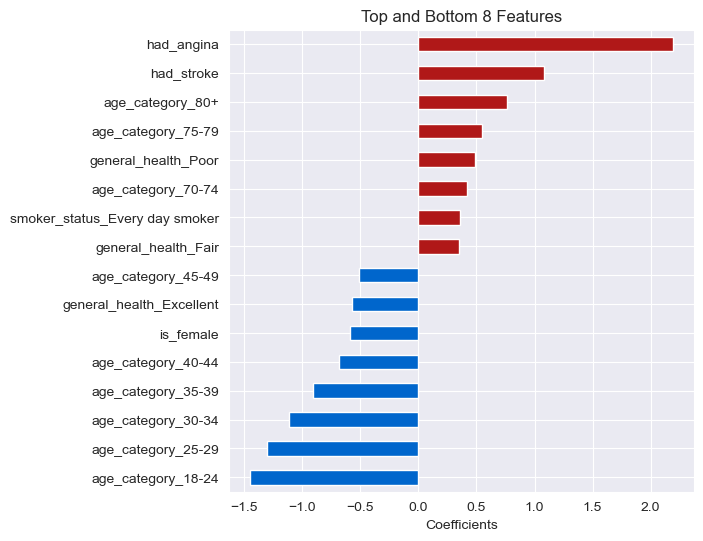

In [109]:
# Create a DataFrame to store top 8 and bottom 8 features
important_features = pd.concat([top_8_features, bottom_8_features], axis=0).sort_values(by='coefficients')
colors = ['#0066CC'] * 8 + ['#B01818'] * 8

important_features['coefficients'].plot(kind='barh', color=colors)
plt.xlabel('Coefficients')
plt.title('Top and Bottom 8 Features')

| Feature Name      | Coefficients | Odds     | Feature Description                   |
|-------------------|--------------|----------|---------------------------------------|
| had_angina        | 2.19        | 8.94     | 1. Angina is chest pain or discomfort that occurs when the heart muscle does not receive enough oxygen-rich blood <br> 2. The presence of angina is a strong indicator of the risk of heart attack, as individuals who have had angina have **8.94 times** the odds of having a heart attack compared to those who haven't experienced angina.   |
| had_stroke        | 1.08       | 2.94     | 1. A stroke is a medical emergency that occurs when blood flow to a part of the brain is interrupted or reduced <br> 2. The presence of stroke is also a powerful indicator of the risk of heart attack. Individuals who have experienced stroke have **2.94 times** the odds of having a heart attack compared to those who haven't had stroke.              |
| age_category_80+  | 0.77       | 2.15     | When individuals reach the age of 80, their likelihood of having a heart attack increases significantly. In fact, their odds of experiencing a heart attack are 2.15 times higher compared to those under the age of 80  |
| general_health_Poor | 0.48     | 1.62     | This variable represents respondents who answered 'Poor' when asked to describe their general health condition. Individuals who perceive their general health as poor have odds of having a heart attack that are 1.62 times higher than those who do not.  |
| general_health_Excellent   | -0.57  |0.56  | Individuals who perceive their general health as excellent have odds of having a heart attack that are 0.56 times lower than those who do not perceive their health in this way.     |
| is_female         |-0.59       | 0.55     | Female is less likely to experience a heart attack. In fact, the odds of experiencing a heart attack is 0.55 lower than male.   |
| age_category_18-24 | -1.45     | 0.23     | Young individuals are less likely to experience a heart attack. The odds of having a heart attack for individuals aged 18 to 24 are 0.23 times lower compared to those aged 25 and older |

## 4. Analysis of False Negatives and False Positives<a class="anchor" id="4"></a>
## 